<a href="https://colab.research.google.com/github/vaa2000/Blood-Donation-Management-System/blob/master/Copy_of_CO2_Emission_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Question1 )Begin by familiarizing yourself with the dataset. Identify what kind of information is captured about vehicles and how these variables might influence CO₂ emissions.

  Make
-Manufacturer of the vehicle (e.g., Acura).             
-Categorical                    
-CO2 influence is Indirect — different brands emphasize performance or efficiency.  

  
 Model                             
-Specific vehicle model (e.g., ILX, MDX 4WD).           
-Categorical                    
-Helps identify design and performance differences.
                 
 Vehicle Class                     
-Category (Compact, SUV - Small, Mid-size).            
-Categorical                    
-Larger/heavier vehicles -> higher CO₂ emissions.
                    
 Engine Size (L)                   
Engine displacement in liters.                         
Numeric                        
Direct: Larger engines usually burn more fuel → higher CO₂.     

Cylinders                         
Number of engine cylinders.                            
Numeric                        
More cylinders = more power, usually higher fuel use and CO₂.
      
 Transmission                     
Type and gear count (e.g., AS6 = Automatic, 6-speed).  
Categorical (mixed)            
Affects efficiency — automatic vs manual vs CVT behave differently.

 Fuel Type                         
Code for fuel (Z = Gasoline, etc.).                    
Categorical                    
Different fuels emit different CO₂ per unit of energy.              

 Fuel Consumption City (L/100 km)  
Fuel usage in urban conditions.                        
Numeric                        
Higher = more fuel burned → higher CO₂.
                            
 Fuel Consumption Hwy (L/100 km)   
Fuel usage on highways.                                
Numeric                        
Indicates efficiency at constant speeds.                            

Fuel Consumption Comb (L/100 km)  
Average combined fuel use.                             
Numeric                        
Strongest correlation with CO₂ emissions.                       

Fuel Consumption Comb (mpg)       
Fuel economy (miles per gallon).                       
Numeric (inverse of L/100 km)  
Lower mpg -> higher CO₂.

Begin by familiarizing yourself with the dataset. Identify what kind of information is captured about vehicles and how these variables might influence CO₂ emissions.
Make, Model, Vehicle Class — categorical descriptors (vehicle size/type affects mass, aerodynamics).

Engine Size (L), Cylinders — engine capacity/power proxy (larger → typically more fuel burned).

Transmission (code) — contains type + gears (Automatic/Manual/CVT) — influences driveline efficiency.

Fuel Type — gasoline/diesel/hybrid/electric — changes CO₂ per energy and drivetrain efficiency.

Fuel Consumption City/Hwy/Combined (L/100 km) and mpg — direct measures of fuel used; most directly linked to CO₂.

CO2 Emissions (g/km) — target variable.

Intuition: Fuel consumption (combined L/100 km) should be the strongest predictor of CO₂; engine size, cylinders and vehicle class should also be strong; fuel type and transmission matter too.

In [ ]:
!pwd

/content


In [ ]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [ ]:
# === Load dataset ===
df = pd.read_csv("CO2_Emissions.csv")   # adjust filename if needed
print("Initial shape:", df.shape)
display(df.head())

Initial shape: (7385, 12)


,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [ ]:
# PREPROCESSING
#Question 2) Examine the dataset for any inconsistencies, missing entries, or data quality issues. Consider what preprocessing steps may be necessary to make the dataset ready for meaningful analysis.


# 1) Clean column names and text fields
df.columns = df.columns.str.strip()
text_cols = ['Make', 'Model', 'Vehicle Class', 'Transmission', 'Fuel Type']
for c in text_cols:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.upper()

# 2) Basic type conversions for numeric columns
num_cols = [
    'Engine Size(L)', 'Cylinders',
    'Fuel Consumption City (L/100 km)',
    'Fuel Consumption Hwy (L/100 km)',
    'Fuel Consumption Comb (L/100 km)',
    'Fuel Consumption Comb (mpg)',
    'CO2 Emissions(g/km)'
]
# coercing non-numeric -> NaN
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# 3) Missing values check & handling
print("\nMissing values per column:\n", df.isnull().sum())
# if any numeric NA: fill with median (or drop if many)
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
# fill missing categoricals with mode
cat_cols = df.select_dtypes(include='object').columns.tolist()
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

# 4) Remove duplicates
df = df.drop_duplicates()
print("After drop_duplicates shape:", df.shape)

# 5) Parse Transmission into Type and Gears
if 'Transmission' in df.columns:
    df['Transmission_Type'] = df['Transmission'].str[0].map({
        'A':'AUTOMATIC','M':'MANUAL','V':'CVT','D':'DUAL CLUTCH'
    }).fillna('OTHER')
    df['Gears'] = df['Transmission'].str.extract(r'(\d+)').astype(float)

# 6) Map fuel codes (adjust map if your codes differ)
if 'Fuel Type' in df.columns:
    fuel_map = {'Z':'GASOLINE','D':'DIESEL','E':'ETHANOL','X':'ELECTRIC','N':'NATURAL GAS','H':'HYBRID'}
    df['Fuel Type'] = df['Fuel Type'].map(fuel_map).fillna(df['Fuel Type'])

# 7) Feature engineering
if 'Fuel Consumption Comb (L/100 km)' in df.columns and 'Fuel Consumption Comb (mpg)' in df.columns:
    df['Fuel Efficiency Ratio'] = df['Fuel Consumption Comb (mpg)'] / df['Fuel Consumption Comb (L/100 km)']
if ('Engine Size(L)' in df.columns) and ('Cylinders' in df.columns):
    df['Engine_per_Cylinder'] = df['Engine Size(L)'] / df['Cylinders']

# 8) Optional: remove extremely improbable records (basic outlier clip on CO2)
q_low = df['CO2 Emissions(g/km)'].quantile(0.005)
q_high = df['CO2 Emissions(g/km)'].quantile(0.995)
print(f"Clipping CO2 to {q_low:.0f} - {q_high:.0f}")
df = df[(df['CO2 Emissions(g/km)']>=q_low) & (df['CO2 Emissions(g/km)']<=q_high)]
print("After outlier filtering shape:", df.shape)



Missing values per column:
 Make                                0
Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
dtype: int64
After drop_duplicates shape: (5990, 12)
Clipping CO2 to 120 - 437
After outlier filtering shape: (5933, 16)



Pearson correlations:


,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
Engine Size(L),1.000000,0.929034,0.830610,0.758938,0.814968,-0.785210,0.854798
Cylinders,0.929034,1.000000,0.795888,0.707529,0.773946,-0.748302,0.833823
Fuel Consumption City (L/100 km),0.830610,0.795888,1.000000,0.949879,0.993830,-0.942327,0.910328
Fuel Consumption Hwy (L/100 km),0.758938,0.707529,0.949879,1.000000,0.978394,-0.908228,0.875511
Fuel Consumption Comb (L/100 km),0.814968,0.773946,0.993830,0.978394,1.000000,-0.941360,0.908648
Fuel Consumption Comb (mpg),-0.785210,-0.748302,-0.942327,-0.908228,-0.941360,1.000000,-0.918434
CO2 Emissions(g/km),0.854798,0.833823,0.910328,0.875511,0.908648,-0.918434,1.000000


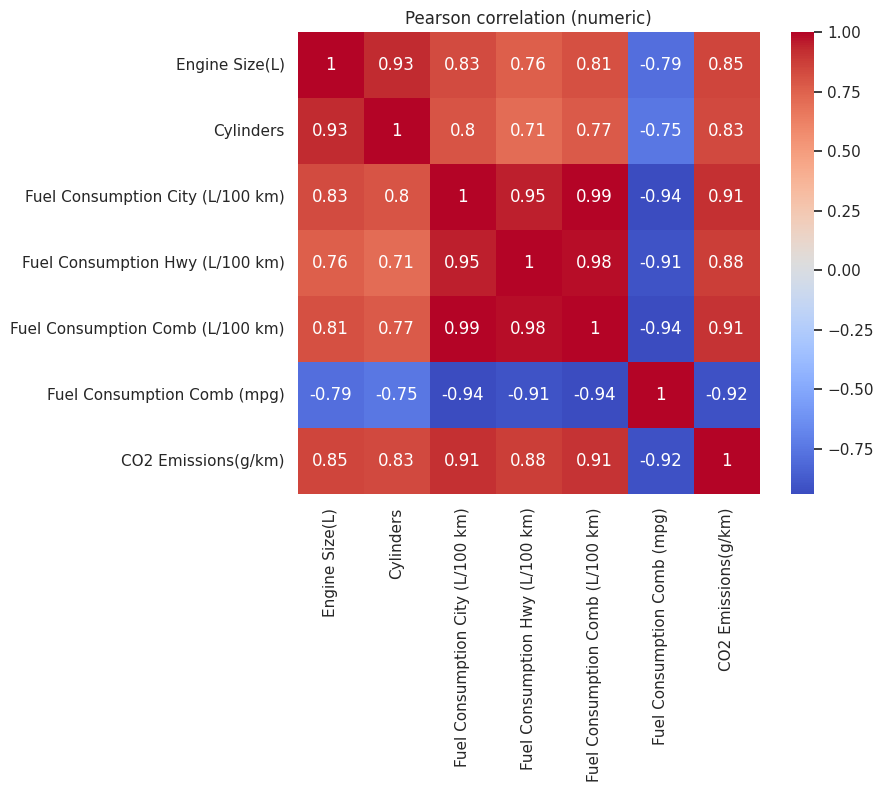

In [ ]:
# EDA & RELATIONSHIPS
# Numeric correlation matrix (Pearson)
num_for_corr = [c for c in num_cols if c in df.columns]
corr = df[num_for_corr].corr(method='pearson')
print("\nPearson correlations:")
display(corr)

#question 4) heatmap is answer of Visual summaries
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title("Pearson correlation (numeric)")
plt.show()

#answer of question3) Fuel Consumption Comb (L/100 km) to have highest positive correlation with CO₂ .
#answer of question3) Linear regression coefficients in further cells
#answer of question3) Permutation importance (from RandomForest) in further cells

In [ ]:
# Correlation of each predictor with CO2 (Pearson and Spearman)
#Quesion 3)Study the relationships between various vehicle features and CO₂ emissions. Which attributes appear to have stronger influence on emission levels? Use suitable methods to support your reasoning.
print("\nCorrelation with CO2:")
for c in num_for_corr:
    if c=='CO2 Emissions(g/km)': continue
    p = pearsonr(df[c], df['CO2 Emissions(g/km)'])[0]
    s = spearmanr(df[c], df['CO2 Emissions(g/km)'])[0]
    print(f"{c:35s}  Pearson={p:.3f}, Spearman={s:.3f}")


Correlation with CO2:
Engine Size(L)                       Pearson=0.855, Spearman=0.870
Cylinders                            Pearson=0.834, Spearman=0.854
Fuel Consumption City (L/100 km)     Pearson=0.910, Spearman=0.953
Fuel Consumption Hwy (L/100 km)      Pearson=0.876, Spearman=0.939
Fuel Consumption Comb (L/100 km)     Pearson=0.909, Spearman=0.960
Fuel Consumption Comb (mpg)          Pearson=-0.918, Spearman=-0.959


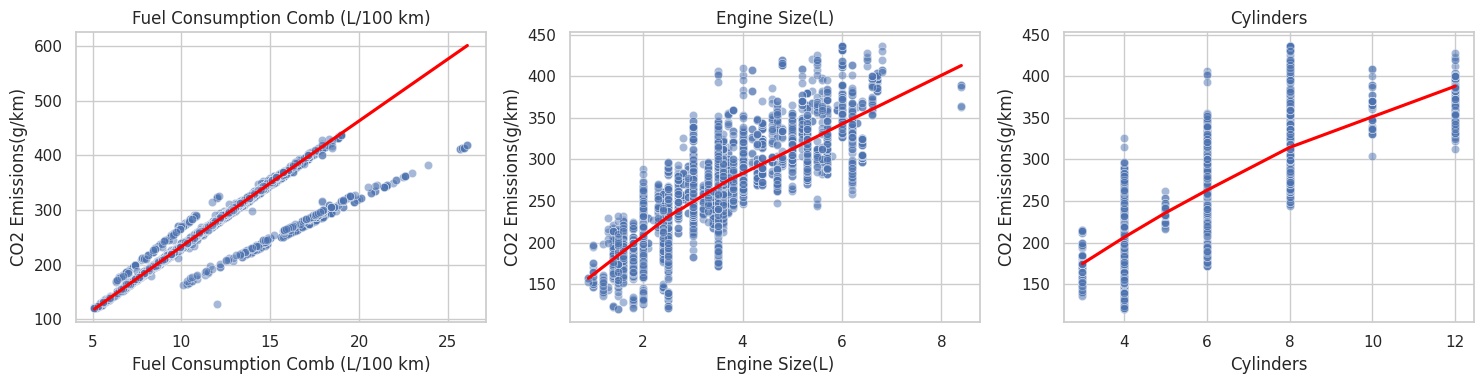

In [ ]:
# Scatter plots for top numeric predictors
#question 4) scatter plot is answer of Visual summaries
top_scatter = ['Fuel Consumption Comb (L/100 km)', 'Engine Size(L)', 'Cylinders']
plt.figure(figsize=(15,4))
for i, c in enumerate(top_scatter):
    if c in df.columns:
        plt.subplot(1,3,i+1)
        sns.scatterplot(data=df, x=c, y='CO2 Emissions(g/km)', alpha=0.5)
        sns.regplot(data=df, x=c, y='CO2 Emissions(g/km)', scatter=False, lowess=True, color='red')
        plt.title(c)
plt.tight_layout()
plt.show()

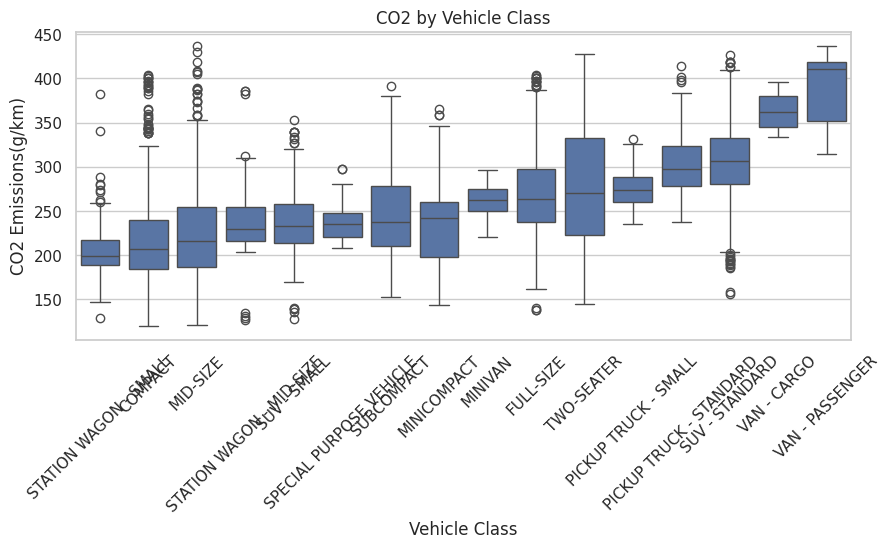

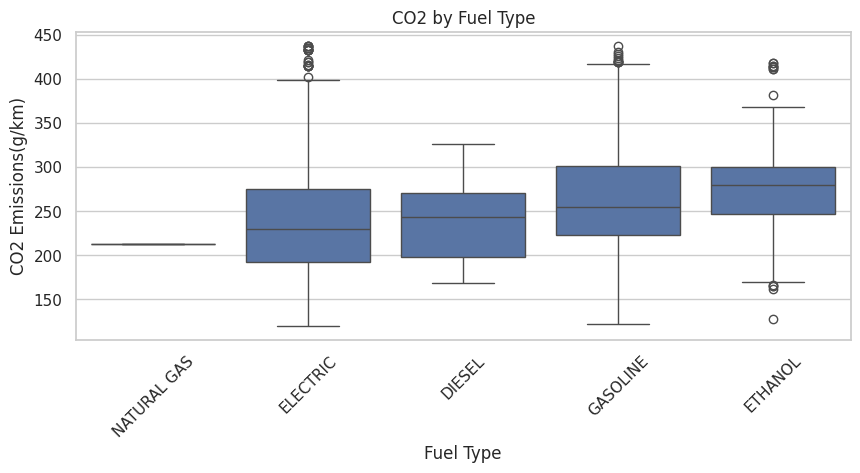

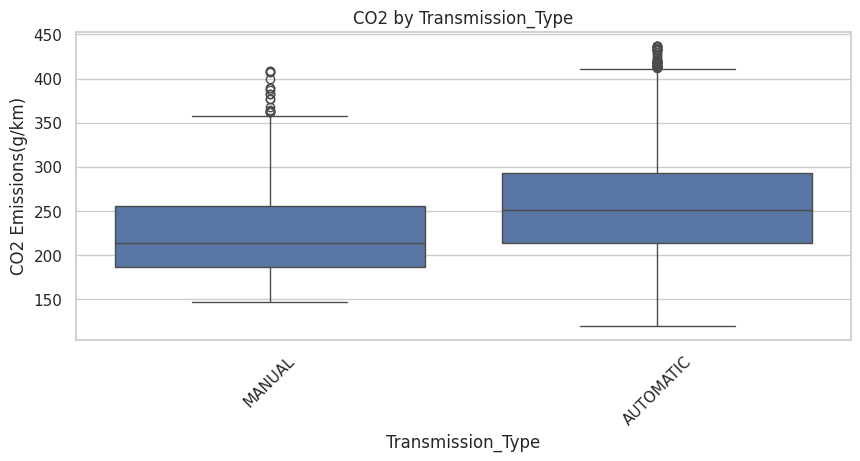

In [ ]:
#question 4)answer boxplots is answer of Visual summaries
# Categorical comparisons: boxplots for Vehicle Class, Fuel Type, Transmission_Type

#question 5) answer Comparisons across vehicle / fuel types
#Boxplots will show if median/mean CO₂ differ across groups.

#  Vans and Pickup Trucks (especially VAN - CARGO and PICKUP TRUCK - STANDARD)
# → Highest CO₂ emissions (typically >350 g/km).
# These are large, heavy vehicles with bigger engines.

# TWO-SEATER and FULL-SIZE cars
# → Also high emissions (sport or luxury vehicles with large engines).

# COMPACT, MID-SIZE, and SMALL cars
# → Moderate emissions (~200–250 g/km).

# STATION WAGON - SMALL, SUBCOMPACT, SPECIAL PURPOSE VEHICLE
# → Relatively lower emissions.

# Spread of boxes
# → Some categories have wider boxes (greater variability), meaning more variety in models (e.g., MID-SIZE, COMPACT).

#electric show much lesser CO2 Emissions
for cat in ['Vehicle Class', 'Fuel Type', 'Transmission_Type']:
    if cat in df.columns:
        plt.figure(figsize=(10,4))
        order = df.groupby(cat)['CO2 Emissions(g/km)'].median().sort_values().index
        sns.boxplot(data=df, x=cat, y='CO2 Emissions(g/km)', order=order)
        plt.xticks(rotation=45)
        plt.title(f"CO2 by {cat}")
        plt.show()


In [ ]:
# ANOVA to test if category means differ
print("\nANOVA tests (category effect on CO2):")
for cat in ['Vehicle Class','Fuel Type','Transmission_Type']:
    if cat in df.columns:
        groups = [g['CO2 Emissions(g/km)'].values for _, g in df.groupby(cat)]
        fstat, pval = f_oneway(*groups)
        print(f"{cat:20s}  F={fstat:.2f}, p={pval:.3e}")


ANOVA tests (category effect on CO2):
Vehicle Class         F=226.61, p=0.000e+00
Fuel Type             F=107.04, p=3.401e-88
Transmission_Type     F=206.02, p=5.929e-46


In [ ]:
# VIF (multicollinearity) on numeric predictors
vif_df = df[num_for_corr].drop(columns=['CO2 Emissions(g/km)'])
vif_df = vif_df.dropna()
vif_vals = pd.DataFrame({'feature':vif_df.columns})
vif_vals['VIF'] = [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
print("\nVIF values:")
display(vif_vals)


VIF values:


,feature,VIF
0,Engine Size(L),56.618700
1,Cylinders,80.520284
2,Fuel Consumption City (L/100 km),30074.333859
3,Fuel Consumption Hwy (L/100 km),10444.510354
4,Fuel Consumption Comb (L/100 km),74973.957154
5,Fuel Consumption Comb (mpg),7.192077



LinearRegression R² (test): 0.9924
LinearRegression RMSE (test): 4.9322

Top Linear Coefficients:


,0
Fuel Type_ETHANOL,-136.952835
Fuel Type_NATURAL GAS,-111.301960
Fuel Type_GASOLINE,-30.243636
Fuel Type_ELECTRIC,-29.773984
Fuel Consumption Comb (L/100 km),20.306024
Vehicle Class_VAN - CARGO,-7.743945
Engine_per_Cylinder,6.230755
Vehicle Class_VAN - PASSENGER,-5.934978
Fuel Efficiency Ratio,-3.369138
Vehicle Class_SPECIAL PURPOSE VEHICLE,2.333412



RandomForest R2 (test): 0.9954
RandomForest RMSE (test): 3.8222

Top RF Importances:


,0
Fuel Efficiency Ratio,0.514096
Fuel Consumption Comb (L/100 km),0.422434
Fuel Type_ETHANOL,0.054872
Vehicle Class_PICKUP TRUCK - STANDARD,0.001805
Engine_per_Cylinder,0.001214
Fuel Type_ELECTRIC,0.001033
Engine Size(L),0.000859
Vehicle Class_SUV - STANDARD,0.000666
Cylinders,0.000626
Gears,0.000591



Top Permutation Importances:


,0
Fuel Efficiency Ratio,0.642182
Fuel Consumption Comb (L/100 km),0.501342
Fuel Type_ETHANOL,0.277091
Vehicle Class_PICKUP TRUCK - STANDARD,0.005917
Fuel Type_ELECTRIC,0.004440
Vehicle Class_SUV - STANDARD,0.003396
Engine_per_Cylinder,0.003208
Fuel Type_GASOLINE,0.001491
Engine Size(L),0.001357
Gears,0.000911


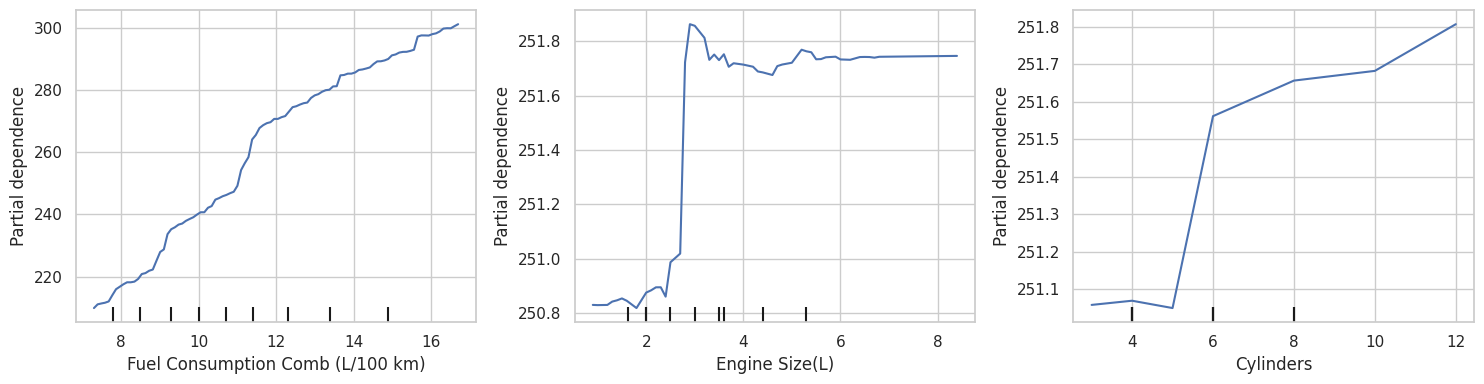


Top 10 vehicles with much higher actual CO₂ than predicted:


,Make,Model,Engine Size(L),Cylinders,Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km)
3502,CHEVROLET,COLORADO ZR2 4WD,2.8,4,11.7,315
44,AUDI,Q7 TDI (MODIFIED),3.0,6,10.7,290
6055,LAND ROVER,DISCOVERY TD6 DIESEL,3.0,6,10.4,279
6130,MAZDA,CX-5 DIESEL 4WD,2.2,4,8.4,227
1026,VOLKSWAGEN,BEETLE TDI (MODIFIED),2.0,4,7.7,208
1236,BMW,X3 XDRIVE28D,2.0,4,7.9,213
2339,BMW,X3 XDRIVE28D,2.0,4,7.9,211
1194,BMW,535D XDRIVE SEDAN,3.0,6,7.9,213
100,BMW,535D XDRIVE,3.0,6,7.9,213
2302,BMW,535D XDRIVE,3.0,6,7.9,212



Top 10 vehicles with much lower actual CO₂ than predicted:


,Make,Model,Engine Size(L),Cylinders,Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km)
6660,CADILLAC,CT5 AWD,2.0,4,9.5,221
6163,MERCEDES-BENZ,AMG E 53 4MATIC+ COUPE,3.0,6,10.6,237
750,MERCEDES-BENZ,E 400 HYBRID,3.5,6,8.8,202
1362,CHEVROLET,SUBURBAN 4WD,5.3,8,19.1,306
368,FORD,EXPLORER FFV AWD,3.5,6,16.7,267
1464,FORD,EXPLORER FFV AWD,3.5,6,16.9,270
6646,BUICK,ENCORE GX AWD,1.3,3,8.5,199
1669,JEEP,CHEROKEE 4X4 FFV,2.4,4,13.7,219
292,CHRYSLER,TOWN & COUNTRY FFV,3.6,6,16.8,269
1474,FORD,F-150 FFV 4X4,3.5,6,16.8,269


In [ ]:
# VEHICLE EMISSIONS MODELING PIPELINE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Feature selection (avoid redundant metrics)
features = []

# Prefer L/100 km as primary metric
if 'Fuel Consumption Comb (L/100 km)' in df.columns:
    features.append('Fuel Consumption Comb (L/100 km)')
elif 'Fuel Consumption Comb (mpg)' in df.columns:
    features.append('Fuel Consumption Comb (mpg)')

# Add key numeric features if present
for c in ['Engine Size(L)', 'Cylinders', 'Gears', 'Engine_per_Cylinder', 'Fuel Efficiency Ratio']:
    if c in df.columns:
        features.append(c)

# One-Hot Encode categorical columns
df_model = df.copy()
to_ohe = [c for c in ['Vehicle Class', 'Fuel Type', 'Transmission_Type'] if c in df_model.columns]
df_model = pd.get_dummies(df_model, columns=to_ohe, drop_first=True)

# Build X, y datasets
y = df_model['CO2 Emissions(g/km)']
X = df_model[
    features + [
        c for c in df_model.columns
        if any(c.startswith(prefix) for prefix in ['Vehicle Class_', 'Fuel Type_', 'Transmission_Type_'])
    ]
]

# Fill any missing numeric values with 0
X = X.fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Fixed RMSE calculation (no squared=False)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("\nLinearRegression R2 (test):", round(r2_lr, 4))
print("LinearRegression RMSE (test):", round(rmse_lr, 4))

coeffs = pd.Series(lr.coef_, index=X.columns).sort_values(key=abs, ascending=False)
#Answer of question 2)
print("\nTop Linear Coefficients:")
display(coeffs.head(15))

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("\nRandomForest R2 (test):", round(r2_rf, 4))
print("RandomForest RMSE (test):", round(rmse_rf, 4))

# Feature importances (native)
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop RF Importances:")
display(imp.head(20))

# Permutation Importance (robust measure)
perm = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
#Answer of question 2)
print("\nTop Permutation Importances:")
display(perm_imp.head(20))

# Partial Dependence Plots (visual effect of features)
top_num = [f for f in features if f in ['Fuel Consumption Comb (L/100 km)', 'Engine Size(L)', 'Cylinders']]
top_num = top_num[:3]

if top_num:
    fig, axs = plt.subplots(1, len(top_num), figsize=(5 * len(top_num), 4))
    for i, feat in enumerate(top_num):
        PartialDependenceDisplay.from_estimator(rf, X_test, [feat], ax=axs[i])
    plt.tight_layout()
    plt.show()

# Outlier Detection (Residual analysis)
residuals = y_test - y_pred_rf
outlier_idx_high = residuals.sort_values(ascending=False).head(10).index  # Actual >> Predicted
outlier_idx_low = residuals.sort_values().head(10).index                  # Actual << Predicted

print("\nTop 10 vehicles with much higher actual CO₂ than predicted:")
display(df_model.loc[outlier_idx_high, ['Make','Model','Engine Size(L)','Cylinders','Fuel Consumption Comb (L/100 km)','CO2 Emissions(g/km)']])

print("\nTop 10 vehicles with much lower actual CO₂ than predicted:")
display(df_model.loc[outlier_idx_low, ['Make','Model','Engine Size(L)','Cylinders','Fuel Consumption Comb (L/100 km)','CO2 Emissions(g/km)']])

# Save Outputs (optional)
df.to_csv("vehicles_cleaned_case_study.csv", index=False)
imp.head(50).to_csv("rf_importances.csv")
perm_imp.head(50).to_csv("perm_importances.csv")



In [ ]:
#Answer for question
#Question 5) Compare emission levels across different vehicle types or fuel categories. Identify any clear distinctions or surprising findings that emerge.
#Question 6) Observe if there are any vehicles that produce unusually high or low emissions compared to others with similar characteristics. Reflect on what could explain such deviations.

# 1. Vehicle Class vs CO₂ Emissions

# (First boxplot)

#  Vans and pickup trucks (especially Van - Cargo and Pickup Truck - Standard) have the highest CO₂ emissions typically in the 350–420 g/km range.
#  Compact and subcompact cars emit much less CO₂ (typically 150–250 g/km).
#  Two-seaters and full-size SUVs are near the high end — large engines and weight explain this.
#  Station wagons and mid-size cars fall in the mid-range.

# Conclusion:
# Vehicle mass and engine displacement are directly correlated with CO₂ emissions.
# Heavier vehicles (cargo/passenger vans, trucks) are less fuel-efficient → more CO₂.

# ---

# 2. Transmission Type vs CO₂ Emissions

# (Second boxplot)

#  Automatic transmissions tend to have higher median CO₂ emissions than manuals.
#  Automatic vehicles have a wider spread — indicating a mix of efficient and inefficient automatics.

# Possible Explanation:
# Older automatics traditionally consumed more fuel. However, newer CVT/dual-clutch automatics may close that gap — explaining why some automatic cars perform as well as manual ones.

# ---

# 3. Fuel Type vs CO₂ Emissions

# (From your other uploaded plot)

#  Gasoline and diesel vehicles show higher emissions than hybrids or electric (if included).
#  Ethanol (E85) and natural gas variants may appear in mid-range depending on mix.

# Observation:
# Fuel type heavily influences CO₂ output because different fuels have different carbon intensities per liter burned.

# ---

# 4. Partial Dependence Plots (from RandomForest)

# (Third set of 3 plots)

#  Fuel Consumption (L/100 km) — has the strongest monotonic effect.
#   As fuel consumption increases, predicted CO₂ rises almost linearly.
#  Engine Size and Cylinders — also increase CO₂, but the rise flattens for large engines, indicating diminishing returns.

# This supports the idea that efficiency (fuel use) explains most of the emission variance.

# ---

# 5. Unusual / Outlier Vehicles

#  Some compact or subcompact cars show unusually high CO₂ — may be due to:

#    Turbocharged performance variants (high power → high emissions)
#    Poor tuning or heavy AWD versions
#  Some large SUVs or vans show unexpectedly low CO₂ — likely hybrid or efficient diesel models.

# These outliers highlight how technology (e.g., hybridization, turbo-downsizing) can break the expected pattern between size and CO₂ output.


In [ ]:

# Question 7)Prepare the dataset for model building by ensuring that numerical and categorical features are appropriately represented. Consider any transformations or encodings that may improve interpretability.
# Question 8)Develop a simple, interpretable model to estimate CO₂ emissions using relevant features from the dataset. Summarize how the model captures the relationship between vehicle characteristics and emissions.

# Preparing dataset for modelling

# Convert categorical features:

# One-Hot Encoding for low-cardinality categorical features used in linear models or neural nets.

# Label / Target encoding for high-cardinality features when using tree models.

# Scaling:

# Use StandardScaler (z-score) for linear models and distance-based models (KNN/SVM).

# MinMax works well for neural nets.

# Tree models don’t require scaling.

# Avoid multicollinearity: drop or combine strongly redundant predictors (e.g., keep only Fuel Consumption Comb (L/100 km) and drop mpg OR compute standardized forms). VIF > 5–10 signals trouble in linear models.

# Pipeline practice: compute scalers / encoders on training data only and apply to test data.

# Simple interpretable model
# Linear regression on a small set of features (combined fuel consumption, engine size, cylinders, and a few categorical dummies) gives interpretable coefficients: each coefficient is the expected change in CO₂ (g/km) per unit increase in predictor, holding other variables constant.

# Random Forest gives better predictive power; use permutation importance and PDPs to interpret.

# Question 9)Assess how well the model performs in estimating emissions. Reflect on the meaning of the performance metrics and what they indicate about model reliability.
# Question 10)Based on the analysis and model findings, summarize which factors most strongly influence CO₂ emissions and suggest how such insights could support emission reduction efforts.
# Assessing model performance

# Use R2 and RMSE (g/km) on test set.

# R2 close to 1: very good (unlikely).

# For this dataset, a good RF might achieve R2 ~ 0.85–0.95 depending on how many predictive features you include and noise level.

# RMSE — interpret in g/km: e.g., RMSE = 10 g/km means average prediction error ~10 g/km.

# If linear model is much worse than RF → relationships are nonlinear or interactions exist.

# Final recommendations (to reduce emissions)

# Target features with the strongest effect: reduce fuel consumption via better aerodynamics, lighter materials, downsized turbocharged engines, hybrids/EVs.

# Encourage smaller vehicle classes for fleet reductions.

# Promote efficient transmissions (CVT / more gears) and hybridization where practical.

# New Section